In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Concatenate, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
from google.colab import files
uploaded = files.upload()

Saving loan_data.csv to loan_data (2).csv


In [7]:
# 1. Load Data
df = pd.read_csv("loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [8]:
# 2. Fitur dan Target
feature_cols = [
    'person_age', 'person_gender', 'person_education', 'person_income',
    'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    'credit_score', 'previous_loan_defaults_on_file']
target_col = 'loan_status'

X = df[feature_cols]
y = df[target_col]

In [28]:
# 3. Preprocessing
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership',
                    'loan_intent', 'previous_loan_defaults_on_file']
numerical_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
                  'credit_score']

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

df['person_income'] = np.log1p(df['person_income'])
df['loan_amnt'] = np.log1p(df['loan_amnt'])
df['credit_score'] = np.log1p(df['credit_score'])


In [29]:
# 4. SMOTE Balancing
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_processed, y)
X_balanced = X_balanced.reshape((X_balanced.shape[0], X_balanced.shape[1], 1))

In [30]:
# 5. Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)

In [31]:
# 6. Focal Loss Function
def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return loss

In [32]:
# 7. Dense Block

def dense_block(x, growth_rate, layers):
    for _ in range(layers):
        bn = BatchNormalization()(x)
        relu = ReLU()(bn)
        conv1 = Conv1D(growth_rate, kernel_size=1, padding='same')(relu)
        conv3 = Conv1D(growth_rate, kernel_size=3, padding='same')(conv1)
        x = Concatenate()([x, conv3])
    return x


In [33]:
# 8. Transition Layer

def transition_layer(x, compression=0.5):
    reduced_filters = int(K.int_shape(x)[-1] * compression)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(reduced_filters, kernel_size=1, padding='same')(x)
    x = AveragePooling1D(pool_size=2, strides=2, padding='same')(x)
    return x

In [34]:
# 9. Build Model

def build_densenet(input_shape, growth_rate=32, num_classes=1):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)

    x = dense_block(x, growth_rate, layers=3)
    x = transition_layer(x)
    x = dense_block(x, growth_rate, layers=3)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [40]:
# 10. Compile and Train
model = build_densenet(input_shape=(X_balanced.shape[1], 1))
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/15
690/690 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.8379 - loss: 0.0221 - precision_9: 0.8077 - recall_9: 0.8901 - val_accuracy: 0.8867 - val_loss: 0.0160 - val_precision_9: 0.8817 - val_recall_9: 0.8942
Epoch 2/15
690/690 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.8845 - loss: 0.0166 - precision_9: 0.8648 - recall_9: 0.9137 - val_accuracy: 0.8769 - val_loss: 0.0179 - val_precision_9: 0.8126 - val_recall_9: 0.9809
Epoch 3/15
690/690 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.8833 - loss: 0.0166 - precision_9: 0.8613 - recall_9: 0.9138 - val_accuracy: 0.8924 - val_loss: 0.0156 - val_precision_9: 0.8492 - val_recall_9: 0.9552
Epoch 4/15
690/690 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.8876 - loss: 0.0159 - precision_9: 0.8689 - recall_9: 0.9122 - val_accuracy: 0.8912 - val_loss: 0.0150 - val_precision_9: 0.8886 - val_recall_9: 0.8954
Epoch 5/15
690/690 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.8866 - loss: 0.0154 - precision_9: 0.8642 - recall_9

In [41]:
# 11. Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     10500
           1       0.88      0.93      0.90     10500

    accuracy                           0.90     21000
   macro avg       0.90      0.90      0.90     21000
weighted avg       0.90      0.90      0.90     21000

ROC-AUC: 0.8986666666666667


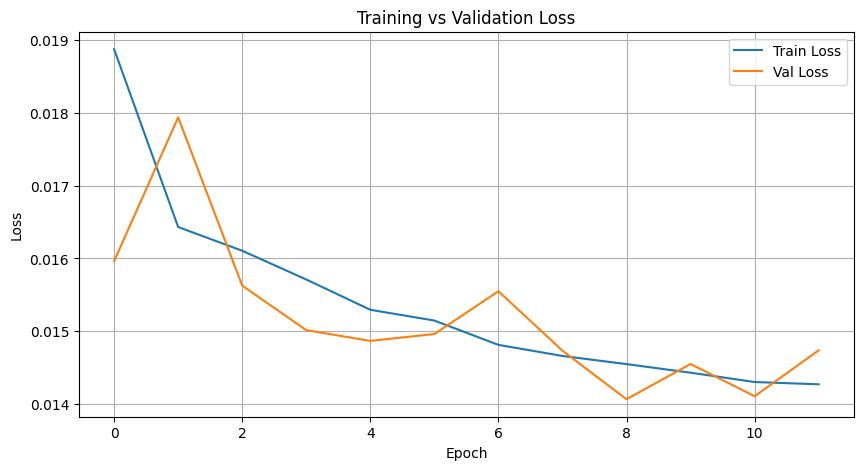

In [42]:
# 12. Plot Overfitting Check
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

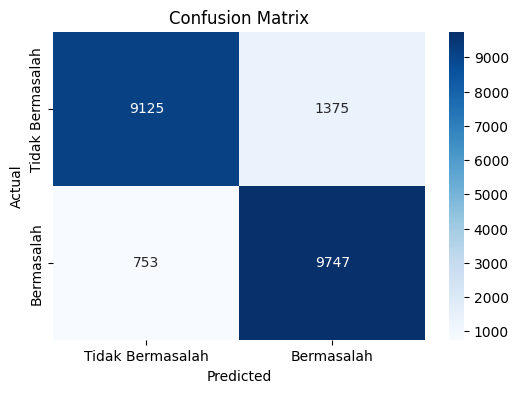

In [43]:
# 12 Confussion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Bermasalah', 'Bermasalah'],
            yticklabels=['Tidak Bermasalah', 'Bermasalah'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()